# Load dataset from NarrativeQA

We use Narrative from Question Generation and RAG Evaluation

In [1]:
import pandas as pd
from Utils import *
data_loader = DatasetLoader()
from datasets import load_dataset
import os

vector_DB = VectorDatabase()
embedder = Embedder()
data_processor = DataProcessor(embedder=embedder, vectordatabase=vector_DB)

DatasetLoads initialized
Connected to Milvus at localhost:19530 with database default.
VectorDatabase initialized.
Initializing sparse embedder...
Embedder initialized
Data Processor initialized


[nltk_data] Downloading package words to /home/yarikama/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
def extract_narrativeqa_text(split='train'):
    # 載入數據集
    dataset = load_dataset("deepmind/narrativeqa", split=split)
    
    # 用於存儲唯一文本的字典
    unique_summaries = {}
    unique_documents = {}
    
    total_summary_chars = 0
    total_document_chars = 0
    
    # 用於存儲問題和答案的列表
    questions = []
    answers = []
    
    # 從每個示例中提取文本
    for example in dataset:
        summary = example['document']['summary']['text']
        document = example['document']['text']
        metadata = example['document']['kind'] + "\\" + example['document']['summary']['title']
        
        # 只有當摘要和文檔都是唯一的時才添加到 df_doc
        if summary not in unique_summaries and document not in unique_documents:
            unique_summaries[summary] = metadata
            unique_documents[document] = metadata
            total_summary_chars += len(summary)
            total_document_chars += len(document)
        
        # 總是添加問題和答案到 df_qa
        questions.append(example['question']['text'])
        answers_text = ""
        for answer in example['answers']:
            answers_text += answer['text'] + ", "
        answers.append(answers_text)
            
    # 從字典創建列表
    summaries = list(unique_summaries.keys())
    documents = list(unique_documents.keys())
    metadata = [unique_summaries[s] for s in summaries]  # 將元數據與摘要對齊
    
    # 計算平均值
    num_examples = len(summaries)
    avg_summary_chars = total_summary_chars / num_examples if num_examples > 0 else 0
    avg_document_chars = total_document_chars / num_examples if num_examples > 0 else 0
    
    # 創建 df_doc DataFrame
    df_doc = pd.DataFrame({
        'summary': summaries,
        'document': documents,
        'metadata': metadata
    })
    
    # 創建 df_qa DataFrame
    df_qa = pd.DataFrame({
        'questions': questions,
        'ground_truths': answers,
        'answers': ['' for _ in range(len(questions))],
        'context': ['' for _ in range(len(questions))]
    })
    
    print(f'唯一文檔數量: {num_examples}')
    print(f'問答對數量: {len(df_qa)}')
    print(f'平均摘要長度: {avg_summary_chars:.2f} 字符')
    print(f'平均文檔長度: {avg_document_chars:.2f} 字符')
    
    return df_doc, df_qa

In [ ]:
# df_doc, df_qa = extract_narrativeqa_text(split="train")
# df_doc.to_parquet(".parquet/narrative_qa_doc_full.parquet")
# df_qa.to_parquet(".parquet/narrative_qa_qa_full.parquet")
df_doc = pd.read_parquet(".parquet/narrative_qa_doc_full.parquet")
df_qa = pd.read_parquet(".parquet/narrative_qa_qa_full.parquet")

df_doc_sample = df_doc.sample(frac=0.01, random_state=42)
# df_qa_sample = df_qa.sample(frac=0.05, random_state=42)
df_doc_sample.to_parquet(".parquet/narrative_qa_doc_sample_11.parquet")
# df_qa_sample.to_parquet(".parquet/narrative_qa_qa_sample_11.parquet")
# df_doc_sample

In [ ]:
# load parquet
df_doc_sample = pd.read_parquet(".parquet/narrative_qa_doc_sample_11.parquet")



# Import Multihop Dataset

In [3]:
import pandas as pd
import json

def read_json_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        dataset = json.load(file)
    return dataset

def transform_to_dataframe(dataset):
    data_list = []
    for data in dataset:
        content = data["body"]
        metadata = {
            "title": data["title"],
            "source": data["source"],
            "published_at": data["published_at"]
        }
        data_list.append({"content": content, "metadata": metadata})
    
    return pd.DataFrame(data_list)

def transform_to_qa_dataframe(dataset):
    df_dataset = pd.DataFrame(dataset)    
    gold_lists = []
    for row in df_dataset["evidence_list"]:
        gold_list = []
        for evidence_list in row:
            gold_list.append({"fact": evidence_list["fact"], "source": evidence_list["source"], "url": evidence_list["url"], "title": evidence_list["title"]})            
        gold_lists.append(gold_list)
    df_dataset["gold_list"] = gold_lists
    df_dataset.drop(columns=["evidence_list"], inplace=True)
    df_dataset["retrieval_list"] = [[] for i in range(len(df_dataset))]
    df_dataset["model_answer"] = ["" for _ in range(len(df_dataset))]
    df_dataset["gold_answer"] = df_dataset["answer"]
    df_dataset.drop(columns=["answer"], inplace=True)
    
    return df_dataset

dataset = read_json_dataset("/home/yarikama/VGMARS/src/.dataset/multihop/MultiHopRAG.json")

df_dataset_multihop = transform_to_qa_dataframe(dataset)
df_dataset_multihop.to_parquet("/home/yarikama/VGMARS/src/.parquet/multihop_dataset.parquet")
df_dataset_multihop


,query,question_type,gold_list,retrieval_list,model_answer,gold_answer
0,Who is the individual associated with the cryp...,inference_query,"[{'fact': 'Before his fall, Bankman-Fried made...",[],,Sam Bankman-Fried
1,Which individual is implicated in both inflati...,inference_query,[{'fact': 'No apartment in New York City has e...,[],,Donald Trump
2,Who is the figure associated with generative A...,inference_query,[{'fact': 'Altman’s exit “is indeed shocking a...,[],,Sam Altman
3,Do the TechCrunch article on software companie...,comparison_query,[{'fact': 'They really just want to be able to...,[],,Yes
4,Which online betting platform provides a welco...,inference_query,[{'fact': 'New customers can get up to $1000 i...,[],,Caesars Sportsbook
...,...,...,...,...,...,...
2551,Who is the individual associated with using FT...,inference_query,"[{'fact': 'It was Bankman-Fried’s decision, sh...",[],,Sam Bankman-Fried
2552,Who is the individual that was once likened to...,inference_query,[{'fact': 'Bankman-Fried was even compared to ...,[],,Sam Bankman-Fried
2553,"Who, according to articles in Sporting News, s...",inference_query,[{'fact': 'If you bet $130 on the Cowboys and ...,[],,Bettors
2554,Does the Cnbc | World Business News Leader art...,comparison_query,"[{'fact': 'During cross-examination, Huang sai...",[],,Yes


In [6]:
retriever = Retriever(vector_DB)
retriever.hybrid_retrieve("multihop", ["Who is Sam Alterman?"])

# Transform the dataframe into .txts

In [2]:

import re
from bs4 import BeautifulSoup
import unicodedata

def preprocess_content(content: str) -> str:
    soup = BeautifulSoup(content, 'html.parser')
    text = soup.get_text()
    text = unicodedata.normalize('NFKC', text)
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'[ \t]+', ' ', text).strip()
    text = re.sub(r'[^\w\s.,!?;:()"-]', '', text)
    text = text.replace('"', '"').replace('"', '"')
    text = re.sub(r'([.,!?;:])\1+', r'\1', text)
    text = re.sub(r'([.,!?;:])\s*', r'\1 ', text)

    return text.strip()

def write_text_to_files_by_metadata(df):
    # Ensure the dataframe has the required columns
    if not all(col in df.columns for col in ['content', 'metadata']):
        raise ValueError("Dataframe must contain 'document' and 'metadata' columns")

    os.makedirs(".txt/", exist_ok=True)
    
    # Dictionary to keep track of file handles
    file_handles = {}

    try:
        for _, row in df.iterrows():
            metadata = row['metadata']
            # content = preprocess_content(row['content'])
            content = row['content']
            filename = re.sub(r'[^\w\-\_\.]', '_', "-".join(metadata.values()))
            filename = f".txt/{filename}.txt"
            if metadata not in file_handles:
                file_handles[metadata] = open(filename, 'a', encoding='utf-8')

            # Write document to file
            file_handles[metadata].write(content + "\n")  # Add two newlines for separation

    finally:
        # Close all file handles
        print("close")
        for handle in file_handles.values():
            handle.close()

    print(f"{len(file_handles)} files have been created")

In [3]:
write_text_to_files_by_metadata(df_dataset)


# Embedder into Milvus (GPU) for txts

In [ ]:
data_processor.directory_files_process("narrative_qa_full_gpu", ".txt/", True, True)

# Import GRAPH RAG data to neo4j

In [7]:
knowledge_DB = KnowledgeGraphDatabase()

In [8]:
knowledge_DB.delete_all()

In [9]:
knowledge_DB.transform_graph_rag_to_neo4j(data_path="/home/yarikama/VGMARS/graph_rag_multihop/output/20240918-104951/artifacts")

In [7]:
retriever = Retriever()
retriever.local_retrieve_community_vector_search(["Who is Sam Alterman?"], 19)

# Test Modular RAG (Narrative QA)

In [5]:
import pandas as pd
rag_evaluation_dataset = pd.read_parquet(".parquet/narrative_qa_qa_sample_11.parquet")
dataset_queries = rag_evaluation_dataset["questions"].tolist()[15:20]
print(dataset_queries)
# print(vector_DB.list_collections())
answer = rag_evaluation_dataset["ground_truths"].tolist()[15:20]
print(answer)


['Why is Hal torn when he grows close to Mary Burke?', 'In what time period does the story end?', "Who is Blank's therapist?", 'What was the island called?', 'Who does Tom get a job with out West to help support his family?']
['He has a fiancee back home. because he has a fiancee back home ', 'The future A future time period. ', 'Dr. Oatman Dr. Oatman. ', 'Devil Island Devil Island ', 'Ned Ned ']


In [6]:
from Module import *
from Config.output_pydantic import *
from langchain_core.runnables.config import RunnableConfig
from IPython.display import Image


config = RunnableConfig(recursion_limit=1000000)
workflow = WorkFlowModularHybridRAG()

results = workflow.graph.stream({
    "dataset_queries": dataset_queries,
    "specific_collection": "narrative_qa_full_gpu",
}, config=config)

for result in results:
    print(result)


Image(workflow.graph.get_graph().draw_mermaid_png())



/opt/anaconda3/envs/poetry310/lib/python3.10/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


NameError: name 'WorkFlowModularHybridRAG' is not defined

In [ ]:
results["all_results"]

In [ ]:
answer

# Test Modular RAG (Multihop)

In [12]:
import pandas as pd
df_dataset_multihop = pd.read_parquet("/home/yarikama/VGMARS/src/.parquet/multihop_dataset.parquet")[20:40]
queries = df_dataset_multihop["query"].to_list()
queries

["Considering the information from an article in The New York Times about the band Used To Be Young's latest tour and a review in Rolling Stone discussing the standout performance of a particular member during a recent concert, which member of Used To Be Young was highlighted for their exceptional solo during the tour's opening night and also plays the instrument that begins with the letter 'B'?",
 'Has the advice provided by Sporting News to bettors regarding the evaluation of betting opportunities and offers involved reading requirements, going with the favored Eagles, and focusing on hype between the reports published on September 28, 2023, and December 18, 2023?',
 'Which company, covered by Engadget and Polygon, is set to release an updated gaming hardware with over 300 improvements on November 16, emphasizing a singular performance target for developers?',
 "Was there inconsistency in Jada Pinkett Smith's statements regarding what she learned from her children after The Independe

2024-09-19 17:32:23,078 - 132922374481408 - milvus_client.py-milvus_client:658 - DEBUG: Created new connection using: 1296c7191a9e4bbd8ff8e654ea93fab7
2024-09-19 17:32:23,136 - 132905514829504 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Initializing sparse embedder...
Embedder initialized
Connected to Milvus at localhost:19530 with database default.
VectorDatabase initialized.
GraphDatabase initialized.
Retriever initialized
Agents initialized (with model: "gpt-4o-mini" and temperature: "0.1")
Tasks initialized
MultiAgent RAG System initialized
Query 0/20
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:33:57,426 - 132905514829504 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
local possible answers: ["During the tour's opening night, the standout member of Used To Be Young who delivered an exceptional solo was BJ, who plays the banjo.", 'BJ, known for his captivating performances, showcased his talent on the bass during the opening night of the tour.', "The member highlighted for their exceptional solo during the tour's opening night is BJ, who plays the bongo."]
local scores: [12, 10]


2024-09-19 17:34:08,652 - 132905514829504 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: []
all scores: [12, 10]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:34:15,631 - 132905514829504 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-19 17:34:16,932 - 132905514829504 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 1/20
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:34:22,149 - 132905101690560 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global possible answers: ['The advice provided by Sporting News to bettors regarding the evaluation of betting opportunities involves reading requirements and understanding the dynamics of the NFL community, particularly focusing on the favored Eagles.', 'Bettors are encouraged to focus on the hype surrounding the Eagles and other teams, as this can influence their betting strategies and decisions.', 'To evaluate betting opportunities effectively, bettors should consider the promotional offers from sportsbooks and the competitive landscape of the NFL, especially as it relates to the Eagles.']
global scores: [80, 80, 60, 20, 15, 15, 10, 10, 10, 10, 10, 5, 5, 5]


2024-09-19 17:34:34,648 - 132905514829504 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [29, 26]
all scores: [80, 80, 60, 29, 26, 20, 15, 15, 10, 10, 10, 10, 10, 5, 5, 5]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:34:46,835 - 132904709523136 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-19 17:34:50,942 - 132904740980416 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 2/20
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:36:38,802 - 132904889878208 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
local possible answers: ['The company set to release the updated gaming hardware with over 300 improvements on November 16 is focused on a singular performance target for developers.', 'On November 16, the company will launch its new gaming hardware, which has been highlighted by Engadget and Polygon for its 300 improvements.', 'The updated gaming hardware, which is set to release on November 16, aims to provide developers with a singular performance target, as covered by Engadget and Polygon.']
local scores: [31]


2024-09-19 17:36:49,491 - 132904709523136 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [97, 97, 76, 28, 20, 12]
all scores: [97, 97, 76, 31, 28, 20, 12]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
 Pydantic validation error: 1 validation error for InformationOrganizationResult
organized_information
  Field required [type=missing, input_value={'title': 'The Steam Deck...3-11-09T18:00:32+00:00'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.8/v/missing. The JSON structure doesn't match the expected model. Attempting alternative conversion method.


2024-09-19 17:36:59,213 - 132904921335488 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-19 17:37:01,756 - 132905101690560 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 3/20
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:37:06,888 - 132904720008896 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global possible answers: ["Jada Pinkett Smith's statements about what she learned from her children may reflect the complex dynamics of her relationship with Will Smith, suggesting that her views on self-acceptance are influenced by her family's experiences.", "The inconsistency in Jada Pinkett Smith's statements could be attributed to the evolving nature of her thoughts on self-acceptance, shaped by her interactions with her children and the public scrutiny they face.", 'After the report by The Independent - Life and Style, Jada Pinkett Smith might have reassessed her views on self-acceptance, leading to different statements reflecting her ongoing journey with her family.']
global scores: [90, 10, 10, 10]


2024-09-19 17:37:21,447 - 132904921335488 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [81, 81, 76, 41, 39, 38, 31, 31, 21, 17]
all scores: [90, 81, 81, 76, 41, 39, 38, 31, 31, 21, 17, 10, 10, 10]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:37:28,642 - 132904740980416 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-19 17:37:32,518 - 132904910849728 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 4/20
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:37:39,383 - 132905133147840 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global possible answers: ['The country in North Africa expected to see a significant rise in GDP is likely Egypt, which recently unveiled an ancient artifact believed to be from the reign of a pharaoh named Tutankhamun.', "Egypt is projected to experience a notable increase in GDP and has recently showcased an ancient artifact from the reign of a pharaoh whose name starts with 'T', specifically Tutankhamun.", 'In North Africa, Egypt is anticipated to see a substantial rise in GDP and has recently revealed an ancient artifact attributed to the pharaoh Tutankhamun.']
global scores: [10]


2024-09-19 17:37:51,523 - 132904931821248 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: []
all scores: [10]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:37:57,490 - 132904910849728 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-19 17:37:59,694 - 132904699037376 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 5/20
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:38:21,411 - 132904730494656 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
local possible answers: ["The news about Taylor Swift's relationship with Travis Kelce aligns with the later report from The Independent, as both sources acknowledge their public appearances and interactions.", "Entertainment Tonight's coverage of Taylor Swift and Travis Kelce's relationship is consistent with The Independent's report, highlighting their significant media presence together.", "The Independent's inquiry into Taylor Swift and Travis Kelce's relationship reflects the ongoing media scrutiny that has been present since their public appearances began.", 'Reports from Entertainment Tonight and The Independent both confirm that Taylor Swift and Travis Kelce have been seen together, suggesting consistency in the news coverage.', "The media narrative surrounding Taylor Swift and Travis Kelce's relationship has remained consistent, as both Entertainment Tonight and The Independent r

2024-09-19 17:38:35,972 - 132905143633600 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 97, 93, 84, 70]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 98, 98, 97, 97, 96, 93, 85, 84, 84, 83, 79, 71, 71, 70, 61, 61, 54, 53, 51, 49, 48, 46, 24, 22, 15]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:38:48,492 - 132905112176320 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-19 17:38:53,813 - 132904900363968 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 6/20
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:38:58,597 - 132905514829504 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global possible answers: ["The portrayal of Google's market practices in reports by The Age before October 22, 2023, has likely remained consistent with The Verge's coverage of the Epic v. Google case, as both sources focus on Google's competitive dynamics and ongoing legal challenges.", "Reports from The Age and The Verge regarding Google's market practices are expected to align, particularly in their emphasis on regulatory scrutiny and the impact of technological advancements on competition.", "Given the ongoing legal challenges faced by Google, it is plausible that The Age's reports reflect similar themes as those found in The Verge's coverage of the Epic v. Google case, particularly regarding antitrust issues."]
global scores: [90, 80, 10, 5]


2024-09-19 17:39:13,577 - 132905122662080 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 98, 97, 97, 97, 97, 97, 96, 96, 94, 91, 90, 90, 89, 89, 88, 87, 86, 85, 83, 81, 81, 80, 80, 79, 79, 77, 77, 74, 62, 59, 56, 54, 47, 47, 31, 13, 13]
all scores: [99, 98, 97, 97, 97, 97, 97, 96, 96, 94, 91, 90, 90, 90, 89, 89, 88, 87, 86, 85, 83, 81, 81, 80, 80, 80, 79, 79, 77, 77, 74, 62, 59, 56, 54, 47, 47, 31, 13, 13, 10, 5]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:39:28,422 - 132904699037376 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-19 17:39:32,282 - 132905112176320 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 7/20
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:39:36,653 - 132905514829504 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global possible answers: ["The TechCrunch article suggests that Amazon's large language model (LLM) is not trained on kids' responses, indicating a focus on adult data sources to ensure compliance and safety. Meanwhile, The Age article raises concerns about TikTok's pixel collecting data without consent, highlighting the need for stricter data privacy regulations.", "According to the TechCrunch article, Amazon's LLM is designed to avoid training on kids' responses, which aligns with industry standards for protecting children's data. In contrast, The Age article points out that TikTok's pixel tracking practices may infringe on user consent, raising ethical questions about data collection.", "The TechCrunch article emphasizes that Amazon's LLM does not utilize kids' responses in its training data, reflecting a commitment to ethical AI practices. Conversely, The Age article expresses concern

2024-09-19 17:39:52,019 - 132905133147840 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 98, 97, 95, 90, 70, 66, 40, 28, 11]
all scores: [99, 99, 98, 97, 95, 90, 90, 85, 80, 70, 70, 66, 40, 28, 20, 20, 20, 20, 15, 15, 15, 11, 10, 10, 10, 10, 10, 10, 10, 5, 5]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:40:00,012 - 132905091204800 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-19 17:40:02,991 - 132904720008896 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 8/20
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:40:08,207 - 132904942307008 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global possible answers: []
global scores: []


2024-09-19 17:40:14,576 - 132904931821248 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [94, 92, 87]
all scores: [94, 92, 87]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
 Pydantic validation error: 1 validation error for InformationOrganizationResult
  Invalid JSON: key must be a string at line 1 column 2 [type=json_invalid, input_value="{'title': 'Nike misses r...-09-28T20:31:00+00:00'}", input_type=str]
    For further information visit https://errors.pydantic.dev/2.8/v/json_invalid. The JSON structure doesn't match the expected model. Attempting alternative conversion method.


2024-09-19 17:40:23,824 - 132904699037376 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-19 17:40:28,170 - 132904921335488 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 9/20
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:40:33,338 - 132904942307008 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global possible answers: ["The coverage of ski resorts by 'The Independent - Travel' likely shifted focus towards Vail, especially considering the prominence of the Shiffrin family in the skiing community.", "After the report on the Swiss slopes of Zermatt and pistes of Vail, 'The Independent - Travel' may have emphasized Vail's significance in their subsequent coverage.", 'The report on Tremblant Ski Resort could indicate a broader interest in ski resorts beyond just Vail, suggesting a diversification in coverage after the initial report.']
global scores: [80, 20, 10, 5]


2024-09-19 17:40:47,613 - 132905133147840 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 99, 98, 98, 98, 98, 97, 97, 97, 96, 96, 95, 92, 91, 84, 82, 78, 77, 73, 65, 62, 53, 47, 37, 14]
all scores: [99, 99, 99, 99, 98, 98, 98, 98, 97, 97, 97, 96, 96, 95, 92, 91, 84, 82, 80, 78, 77, 73, 65, 62, 53, 47, 37, 20, 14, 10, 5]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:41:05,829 - 132905091204800 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-19 17:41:09,622 - 132904730494656 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 10/20
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:41:16,087 - 132904709523136 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global possible answers: ["Google is the company that spent billions to maintain its default search engine status across various devices and platforms, and it was considered by a major tech competitor as the only valid option for such services at the time of their deal. Additionally, Google is currently facing a class action lawsuit for allegedly harming news publishers' revenues through its business practices.", "The dominant player in the technology sector, Google, not only invested heavily to secure its position as the default search engine across various platforms but was also viewed by a major competitor as the sole viable option for search services during their negotiations. Furthermore, Google is involved in a class action lawsuit regarding its impact on news publishers' revenue."]
global scores: [90, 90, 80, 50, 30, 20, 20, 10, 10, 10, 10, 10, 5, 5]


2024-09-19 17:41:29,018 - 132905514829504 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 99, 94, 93, 89, 65, 42, 21, 15, 10]
all scores: [99, 99, 99, 99, 94, 93, 90, 90, 89, 80, 65, 50, 42, 30, 21, 20, 20, 15, 10, 10, 10, 10, 10, 10, 5, 5]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:41:56,561 - 132904720008896 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-19 17:41:59,718 - 132905133147840 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 11/20
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:42:29,280 - 132904740980416 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
local possible answers: []
local scores: [73]


2024-09-19 17:42:35,617 - 132904720008896 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: []
all scores: [73]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:42:39,774 - 132904942307008 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-19 17:42:41,428 - 132905122662080 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 12/20
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:42:47,560 - 132905133147840 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global possible answers: ['The individual associated with OpenAI, recognized for both his vision of AI agents and his generosity, is likely Sam Altman, who has made headlines in both Fortune and TechCrunch for his controversial departure from the company.', 'Sam Altman, known for his significant contributions to OpenAI and his philanthropic efforts, has been in the news for his departure from the organization, which has sparked discussions in major publications like Fortune and TechCrunch.', 'The person often linked to OpenAI and noted for his vision in AI development is Sam Altman, whose recent exit from the company has been a topic of interest in both Fortune and TechCrunch.']
global scores: [90, 90, 80, 20, 20, 20, 20, 15, 15, 15, 15, 10, 10, 10, 10, 10, 10, 10, 10, 5, 5, 5]


2024-09-19 17:42:58,485 - 132905112176320 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 98, 98, 98, 98, 98, 97, 96, 96, 96, 95, 94, 93, 92, 91, 90, 90, 89, 87, 84, 76, 76, 75, 75, 72, 68, 64, 63, 41]
all scores: [99, 99, 99, 98, 98, 98, 98, 98, 97, 96, 96, 96, 95, 94, 93, 92, 91, 90, 90, 90, 90, 89, 87, 84, 80, 76, 76, 75, 75, 72, 68, 64, 63, 41, 20, 20, 20, 20, 15, 15, 15, 15, 10, 10, 10, 10, 10, 10, 10, 10, 5, 5, 5]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:43:08,321 - 132904910849728 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-19 17:43:13,240 - 132905514829504 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 13/20
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:43:21,029 - 132905143633600 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global possible answers: ['The company that recently reported significant profitability in the third quarter is likely Meta, which has faced criticism for not adequately preventing incidents and streamlining driver sign-ups.', 'Despite being aware of safety concerns since 2014, Meta has introduced new app features to address them, but criticism remains regarding their effectiveness.', "Meta's profitability in the third quarter has been overshadowed by ongoing concerns about their safety measures and driver sign-up processes."]
global scores: [90, 70, 60, 50, 30, 30, 30, 25, 20, 20, 20, 15, 15, 10, 10, 10, 10, 10, 10, 5, 5, 5, 5]


2024-09-19 17:43:33,508 - 132904942307008 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [95, 79, 67, 57, 16]
all scores: [95, 90, 79, 70, 67, 60, 57, 50, 30, 30, 30, 25, 20, 20, 20, 16, 15, 15, 10, 10, 10, 10, 10, 10, 5, 5, 5, 5]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:43:48,656 - 132904931821248 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-19 17:43:51,939 - 132904730494656 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 14/20
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:43:57,249 - 132905143633600 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global possible answers: ["TechCrunch's reporting on Google's financial strategies and the subsequent class action antitrust suit may reflect a dual narrative, where Google's competitive practices are portrayed as both innovative and potentially monopolistic.", "The inconsistency in TechCrunch's portrayal of Google's competitive practices could stem from the contrasting focus on financial strategies aimed at maintaining dominance versus the legal challenges that question the fairness of those practices.", "While TechCrunch highlights Google's efforts to sustain its search engine dominance, the class action antitrust suit suggests a critical view of those same practices, indicating a potential inconsistency in how these strategies are perceived."]
global scores: [90, 30, 20, 10, 10, 10, 10, 10, 5, 5]


2024-09-19 17:44:08,018 - 132905122662080 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 98, 96, 95, 94, 93, 92, 91, 89, 89, 85, 60, 53, 46, 33, 24, 24, 21, 16, 12]
all scores: [99, 99, 99, 98, 96, 95, 94, 93, 92, 91, 90, 89, 89, 85, 60, 53, 46, 33, 30, 24, 24, 21, 20, 16, 12, 10, 10, 10, 10, 10, 5, 5]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
 Pydantic validation error: 1 validation error for InformationOrganizationResult
  Invalid JSON: key must be a string at line 1 column 2 [type=json_invalid, input_value="{'title': '5 things we l...-12-15T17:56:02+00:00'}", input_type=str]
    For further information visit https://errors.pydantic.dev/2.8/v/json_invalid. The JSON structure doesn't match the expected model. Attempting alternative conversion method.


2024-09-19 17:44:20,774 - 132904900363968 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-19 17:44:25,247 - 132904931821248 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 15/20
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:44:29,769 - 132904720008896 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global possible answers: ['The TechCrunch article on GPT-4 suggests that prompting toxic output may be easier compared to other models due to its advanced capabilities and the nuances in its training data.', "The TechCrunch article on Meta's open-source AI approach indicates concerns about potential dangers and disinformation, particularly in the context of competition with industry giants like Google, OpenAI, and Microsoft.", 'The discussions surrounding AI regulation by the Biden Administration highlight the need for oversight in AI technologies, which may relate to the concerns raised in the TechCrunch articles about the implications of AI outputs.', "Meta's challenges with regulatory frameworks suggest that their open-source AI approach could exacerbate issues of misinformation, especially when compared to the more controlled environments of competitors like OpenAI and Google."]
globa

2024-09-19 17:44:42,072 - 132904709523136 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 98, 98, 97, 96, 95, 90, 88, 87, 85, 84, 79, 78, 77, 75, 73, 66, 66, 55, 50, 29, 28, 26, 26, 19, 18, 16, 16, 14, 12]
all scores: [99, 99, 98, 98, 97, 96, 95, 90, 90, 90, 88, 87, 85, 84, 80, 80, 79, 78, 77, 75, 73, 70, 66, 66, 55, 50, 29, 28, 26, 26, 20, 20, 20, 19, 18, 16, 16, 15, 14, 12, 10, 10, 10, 10, 10, 10]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:44:49,701 - 132904931821248 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-19 17:44:56,819 - 132905122662080 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 16/20
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:45:48,948 - 132904740980416 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
local possible answers: ['The Sporting News article claims that Caesars Sportsbook offers a cash-out option for early bet settlement, while the CBSSports.com article focuses on the welcome bonus offer for new customers.', 'According to the Sporting News, Caesars Sportsbook provides a cash-out option, whereas the CBSSports.com article highlights the welcome bonus for new users.', 'The articles suggest that Caesars Sportsbook has a cash-out feature for early bet settlement, while also promoting a welcome bonus for new customers.', 'While the Sporting News mentions a cash-out option, CBSSports.com emphasizes the welcome bonus available for new users at Caesars Sportsbook.', 'The Sporting News article indicates that Caesars Sportsbook offers a cash-out option, contrasting with the focus on welcome bonuses in the CBSSports.com article.']
local scores: [99, 99, 99, 99, 99, 89, 87, 86, 86, 82, 8

2024-09-19 17:46:02,411 - 132904931821248 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 91, 91, 90, 87, 70, 67, 50, 20, 11]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 91, 91, 90, 89, 87, 87, 86, 86, 82, 81, 76, 70, 67, 53, 50, 35, 26, 25, 20, 14, 11]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:46:08,228 - 132905514829504 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-19 17:46:11,546 - 132905143633600 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 17/20
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:46:16,992 - 132904730494656 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
global possible answers: ['CIOs are more cautious in their AI adoption strategy due to regulatory considerations and the complexities of integrating AI technologies into existing systems, while business leaders believe AI will be essential for all businesses within five years.', 'The cautious approach of CIOs in AI adoption is influenced by the need for compliance with emerging regulations, contrasting with the belief of business leaders that AI will become a critical component of business operations in the near future.', "While business leaders are optimistic about AI's potential, CIOs are taking a more measured approach, focusing on the implications of AI technologies and the need for strategic planning before widespread adoption."]
global scores: [90, 90, 90, 80, 20, 15, 15, 10, 10, 10, 10, 10, 10, 5, 5]


2024-09-19 17:46:28,495 - 132904900363968 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 80, 73, 66, 51, 40, 32]
all scores: [99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 90, 90, 90, 80, 80, 73, 66, 51, 40, 32, 20, 15, 15, 10, 10, 10, 10, 10, 10, 5, 5]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:46:42,084 - 132905133147840 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-19 17:46:46,804 - 132904709523136 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 18/20
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:46:51,360 - 132905122662080 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
local possible answers: ["The first character of the European country where Sygic is headquartered could be 'S', and the last character of the name of Sygic's CEO could be 'k'.", "If Sygic is based in Slovakia, the first character would be 'S', and if the CEO's name ends with 'k', the answer could be 'k'.", "Assuming Sygic is in a country starting with 'S' and the CEO's name ends with 'k', the letters would be 'S' and 'k'."]
local scores: [50, 13, 11]


2024-09-19 17:47:00,480 - 132905112176320 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: []
all scores: [50, 13, 11]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:47:05,653 - 132904910849728 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed
2024-09-19 17:47:07,273 - 132905091204800 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


Query 19/20
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:47:30,023 - 132904900363968 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.
local possible answers: ["The CEO of Pets Best Insurance Services is likely to start with the letter 'J', as John J. Ray III is a prominent figure in the insurance industry.", "Given the lack of specific information about Pets Best Insurance Services, one might speculate that the CEO's name starts with 'J', similar to John J. Ray III.", "While the data does not directly answer the query, it is plausible that the CEO of Pets Best Insurance Services has a name starting with 'J', reflecting common naming conventions in the industry."]
local scores: [19, 17]


2024-09-19 17:47:39,697 - 132905514829504 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


detail scores: []
all scores: [19, 17]
 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


2024-09-19 17:47:44,352 - 132904889878208 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


user_query
specific_collection
use_cohere_reranker
user_query_classification_result
query_process_result
sub_queries_classification_result
global_topic_searching_and_hyde_result
local_topic_searching_and_hyde_result
detailed_search_result
information_organization_result
response_audit_result
retrieval_data
global_mapping_result
local_mapping_result
detail_mapping_result
generation_result
repeat_times
dataset_queries
all_results
all_contexts_ragas
all_contexts_multihop


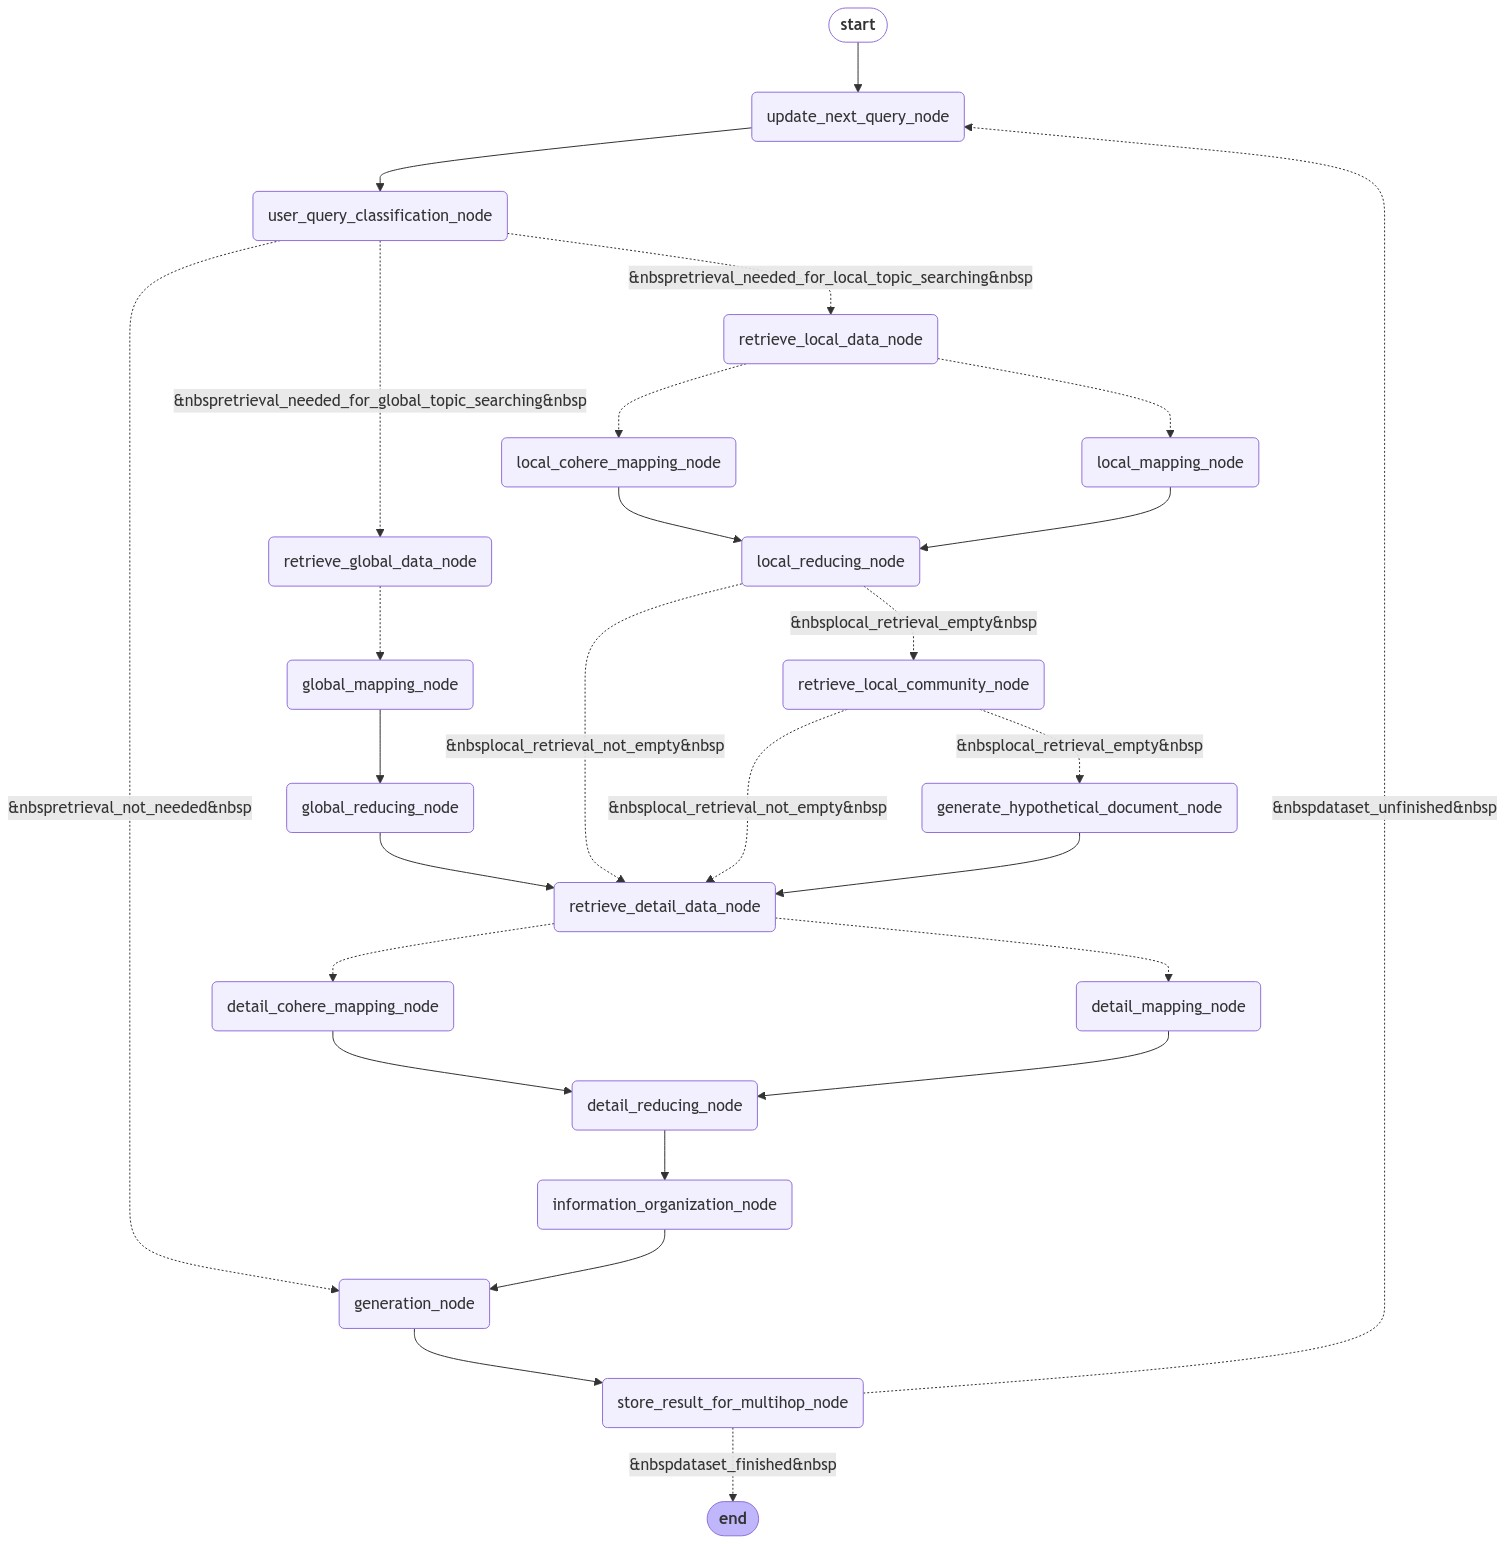

In [10]:
from Module import *
from Config.output_pydantic import *
from langchain_core.runnables.config import RunnableConfig
from IPython.display import Image

config = RunnableConfig(recursion_limit=1000000)
workflow = WorkFlowModularHybridRAGMultiHopRAG()

results = workflow.graph.invoke({
    "dataset_queries": queries,
    "specific_collection": "multihop",
    "use_cohere_reranker": True,
}, config=config)

for result in results:
    print(result)
    
Image(workflow.graph.get_graph().draw_mermaid_png())


In [19]:
df_dataset_multihop["retrieval_list"] = results["all_contexts_multihop"]
df_dataset_multihop["model_answer"] = results["all_results"]
df_dataset_multihop.to_json("/home/yarikama/VGMARS/src/.dataset/multihop/result_sample_10.json", orient="records", indent=4)
df_dataset_multihop

,query,question_type,gold_list,retrieval_list,model_answer,gold_answer
20,Considering the information from an article in...,null_query,[],[],I do not have enough information to answer the...,Insufficient information.
21,Has the advice provided by Sporting News to be...,temporal_query,[{'fact': 'We urge you to read the requirement...,[{'text': 'FanDuel promo code link for MNF Eag...,"Yes, the advice provided by Sporting News to b...",no
22,"Which company, covered by Engadget and Polygon...",inference_query,[{'fact': 'Valve has announced a new Steam Dec...,"[{'text': 'Finally, there’s also a Limited Edi...",Valve is set to release an updated gaming hard...,Valve
23,Was there inconsistency in Jada Pinkett Smith'...,temporal_query,[{'fact': 'This isn’t the first time that Jada...,[{'text': 'The Fresh Prince of Bel-Air star ha...,"No, there was no inconsistency in Jada Pinkett...",no
24,Considering the economic forecasts from a Bloo...,null_query,[],[],"Based on the information provided, I cannot de...",Insufficient information.
25,Was the news about Taylor Swift's relationship...,temporal_query,"[{'fact': 'On his podcast, he later invited th...",[{'text': 'Stay ahead of the trend in fashion ...,"No, the news about Taylor Swift's relationship...",no
26,Has the portrayal of Google's market practices...,temporal_query,[{'fact': 'This whole line of argument is call...,[{'text': 'Google CEO Sundar Pichai testified ...,"Yes, the portrayal of Google's market practice...",no
27,Does the TechCrunch article suggest that Amazo...,comparison_query,"[{'fact': 'In terms of privacy, the company no...",[{'text': '“We do want to integrate an LLM in ...,"Yes, the TechCrunch article suggests that Amaz...",Yes
28,Did the report from Cnbc | World Business News...,comparison_query,[{'fact': 'Sales in its Latin America and Asia...,"[{'text': 'In Europe, the Middle East and Afri...","Yes, both reports indicate a decrease in their...",no
29,Did the coverage of ski resorts by 'The Indepe...,temporal_query,[{'fact': 'Quebec’s premier ski resort sits at...,[{'text': 'Tremblant Tremblant is Quebec’s pr...,"Yes, the coverage of ski resorts by 'The Indep...",no


# Use RAGAS to Evaluate Multihop

In [20]:
ragas_multihop = pd.DataFrame({
    "question": df_dataset_multihop["query"],
    "answer": df_dataset_multihop["model_answer"],
    "contexts": results["all_contexts_ragas"],
    "ground_truth": df_dataset_multihop["gold_answer"]
})
ragas_multihop

,question,answer,contexts,ground_truth
20,Considering the information from an article in...,I do not have enough information to answer the...,[Retrieved Data: ['BJ is the son of Alicia Plu...,Insufficient information.
21,Has the advice provided by Sporting News to be...,"Yes, the advice provided by Sporting News to b...",[The advice provided by Sporting News to betto...,no
22,"Which company, covered by Engadget and Polygon...",Valve is set to release an updated gaming hard...,[Valve is set to release an updated gaming har...,Valve
23,Was there inconsistency in Jada Pinkett Smith'...,"No, there was no inconsistency in Jada Pinkett...","[On 16 October, Jada Pinkett Smith stated duri...",no
24,Considering the economic forecasts from a Bloo...,"Based on the information provided, I cannot de...",[The community encompasses key entities involv...,Insufficient information.
25,Was the news about Taylor Swift's relationship...,"No, the news about Taylor Swift's relationship...",[1. Taylor Swift revealed in an interview with...,no
26,Has the portrayal of Google's market practices...,"Yes, the portrayal of Google's market practice...",[The Age's report on Google's market practices...,no
27,Does the TechCrunch article suggest that Amazo...,"Yes, the TechCrunch article suggests that Amaz...",[Amazon's large language model (LLM) is not tr...,Yes
28,Did the report from Cnbc | World Business News...,"Yes, both reports indicate a decrease in their...","[In Europe, the Middle East and Africa, sales ...",no
29,Did the coverage of ski resorts by 'The Indepe...,"Yes, the coverage of ski resorts by 'The Indep...","[1. On October 13, 2023, 'The Independent - Tr...",no


In [21]:
from datasets import Dataset
ragas_multihop_evaluation = Dataset.from_pandas(ragas_multihop)
ragas_multihop_evaluation

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 20
})

In [22]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset = ragas_multihop_evaluation, 
    metrics=[
        faithfulness,
        answer_relevancy,
        context_precision,
        context_recall,
    ],
)

df = result.to_pandas()
df

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_precision,context_recall
0,Considering the information from an article in...,I do not have enough information to answer the...,[Retrieved Data: ['BJ is the son of Alicia Plu...,Insufficient information.,0.833333,0.000000,0.325000,0.000000
1,Has the advice provided by Sporting News to be...,"Yes, the advice provided by Sporting News to b...",[The advice provided by Sporting News to betto...,no,0.916667,0.903719,0.000000,1.000000
2,"Which company, covered by Engadget and Polygon...",Valve is set to release an updated gaming hard...,[Valve is set to release an updated gaming har...,Valve,1.000000,0.822531,0.642857,1.000000
3,Was there inconsistency in Jada Pinkett Smith'...,"No, there was no inconsistency in Jada Pinkett...","[On 16 October, Jada Pinkett Smith stated duri...",no,1.000000,0.927652,0.733333,1.000000
4,Considering the economic forecasts from a Bloo...,"Based on the information provided, I cannot de...",[The community encompasses key entities involv...,Insufficient information.,0.833333,0.000000,0.166667,1.000000
5,Was the news about Taylor Swift's relationship...,"No, the news about Taylor Swift's relationship...",[1. Taylor Swift revealed in an interview with...,no,1.000000,0.943957,0.950000,0.000000
6,Has the portrayal of Google's market practices...,"Yes, the portrayal of Google's market practice...",[The Age's report on Google's market practices...,no,1.000000,0.920056,0.833333,0.800000
7,Does the TechCrunch article suggest that Amazo...,"Yes, the TechCrunch article suggests that Amaz...",[Amazon's large language model (LLM) is not tr...,Yes,1.000000,0.934717,0.700000,1.000000
8,Did the report from Cnbc | World Business News...,"Yes, both reports indicate a decrease in their...","[In Europe, the Middle East and Africa, sales ...",no,0.812500,0.880171,0.500000,1.000000
9,Did the coverage of ski resorts by 'The Indepe...,"Yes, the coverage of ski resorts by 'The Indep...","[1. On October 13, 2023, 'The Independent - Tr...",no,1.000000,0.949352,0.383333,0.750000


# Test out Retriever for local retriever and global retriever

In [ ]:
from Utils import *
retriever = Retriever()
knowledge_DB = KnowledgeGraphDatabase()
# knowledge_DB.create_entity_vector_index()
# knowledge_DB.create_community_weight()
global_result = retriever.global_retrieve(0)
local_result = retriever.local_retrieve(["What is the meaning of life"])

In [ ]:
local_result

In [ ]:
global_result["communities"]

In [ ]:
import Config.constants as const
import json
from MultiAgent import *
from Utils import *

retriever = Retriever()
multi_agent = MultiAgent_RAG()
# all_communities = retriever.global_retrieve(0)["communities"]

# batches = []
# for i in range(0, len(all_communities), const.NODE_BATCH_SIZE):
#     batch_communities = all_communities[i:i + const.NODE_BATCH_SIZE]
#     batches.append({
#         "user_query": "What is the meaning of life",
#         "sub_queries": [],
#         "batch_communities": batch_communities,
#         "batch_size": len(batch_communities),
#     })


# all_scores = multi_agent.topic_reranking_run_batch_async(node_batch_inputs=batches).relevant_scores
# print(all_scores)
# print(len(all_scores))
# print(len(all_communities))

multi_agent.user_query_classification_run(user_query="Why does the author choose to use first-person point of view in this article?")





In [ ]:
from Utils import *
retriever = Retriever()
retriever.hybrid_retrieve(collection_name="narrative_qa_full_gpu", query_texts=["What is the meaning of life"])